# Hornet and Wasp Classification with YOLO Integration

This notebook implements and compares different deep learning approaches for classifying hornets and wasps:
- **Model 1:** Custom CNN from scratch
- **Model 2:** Transfer Learning with pre-trained ResNet50
- **Model 3:** Vision Transformer (ViT)
- **Model 4:** Object Detection + Cropped Classification (using YOLO bounding boxes)

**Dataset:**
- Vespa_crabro (Class 1): 954 train, 100 validation images
- Vespa_velutina (Class 0): 1,102 train, 100 validation images  
- Vespula_sp (Class 2): 1,032 train, 97 validation images
- Total: 3,088 training, 297 validation images
- **YOLO Labels:** Bounding box annotations available for precise localization

## 1. Setup and Data Exploration

### Import Libraries and Setup

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import os
from PIL import Image, ImageDraw
import random
from pathlib import Path
import time
from collections import defaultdict
import cv2
from torch.utils.data import Dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Memory: 7.7 GB


In [15]:
# Data paths
train_dir = 'dataset/data3000/data/train/images'
val_dir = 'dataset/data3000/data/val/images'

# Get class names
class_names = sorted(os.listdir(train_dir))
print(f"Classes: {class_names}")
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Count images per class
for split, split_dir in [('Train', train_dir), ('Validation', val_dir)]:
    print(f"\n{split} set distribution:")
    total = 0
    for class_name in class_names:
        class_path = os.path.join(split_dir, class_name)
        count = len(os.listdir(class_path))
        total += count
        print(f"  {class_name}: {count} images")
    print(f"  Total: {total} images")

# Check label files
print("\n📋 YOLO Label Analysis:")
train_labels_dir = 'dataset/data3000/data/train/labels'
val_labels_dir = 'dataset/data3000/data/val/labels'

# Class mapping from YOLO labels (based on inspection)
yolo_class_mapping = {
    0: 'Vespa_velutina',
    1: 'Vespa_crabro', 
    2: 'Vespula_sp'
}
print(f"YOLO class mapping: {yolo_class_mapping}")

# Count label files
for split, labels_dir in [('Train', train_labels_dir), ('Validation', val_labels_dir)]:
    print(f"\n{split} labels distribution:")
    total = 0
    for class_name in class_names:
        labels_path = os.path.join(labels_dir, class_name)
        if os.path.exists(labels_path):
            count = len([f for f in os.listdir(labels_path) if f.endswith('.txt')])
            total += count
            print(f"  {class_name}: {count} label files")
    print(f"  Total: {total} label files")

Classes: ['Vespa_crabro', 'Vespa_velutina', 'Vespula_sp']
Number of classes: 3

Train set distribution:
  Vespa_crabro: 954 images
  Vespa_velutina: 1102 images
  Vespula_sp: 1032 images
  Total: 3088 images

Validation set distribution:
  Vespa_crabro: 100 images
  Vespa_velutina: 100 images
  Vespula_sp: 97 images
  Total: 297 images

📋 YOLO Label Analysis:
YOLO class mapping: {0: 'Vespa_velutina', 1: 'Vespa_crabro', 2: 'Vespula_sp'}

Train labels distribution:
  Vespa_crabro: 954 label files
  Vespa_velutina: 1102 label files
  Vespula_sp: 772 label files
  Total: 2828 label files

Validation labels distribution:
  Vespa_crabro: 100 label files
  Vespa_velutina: 100 label files
  Vespula_sp: 100 label files
  Total: 300 label files


### Visualize YOLO Bounding Boxes

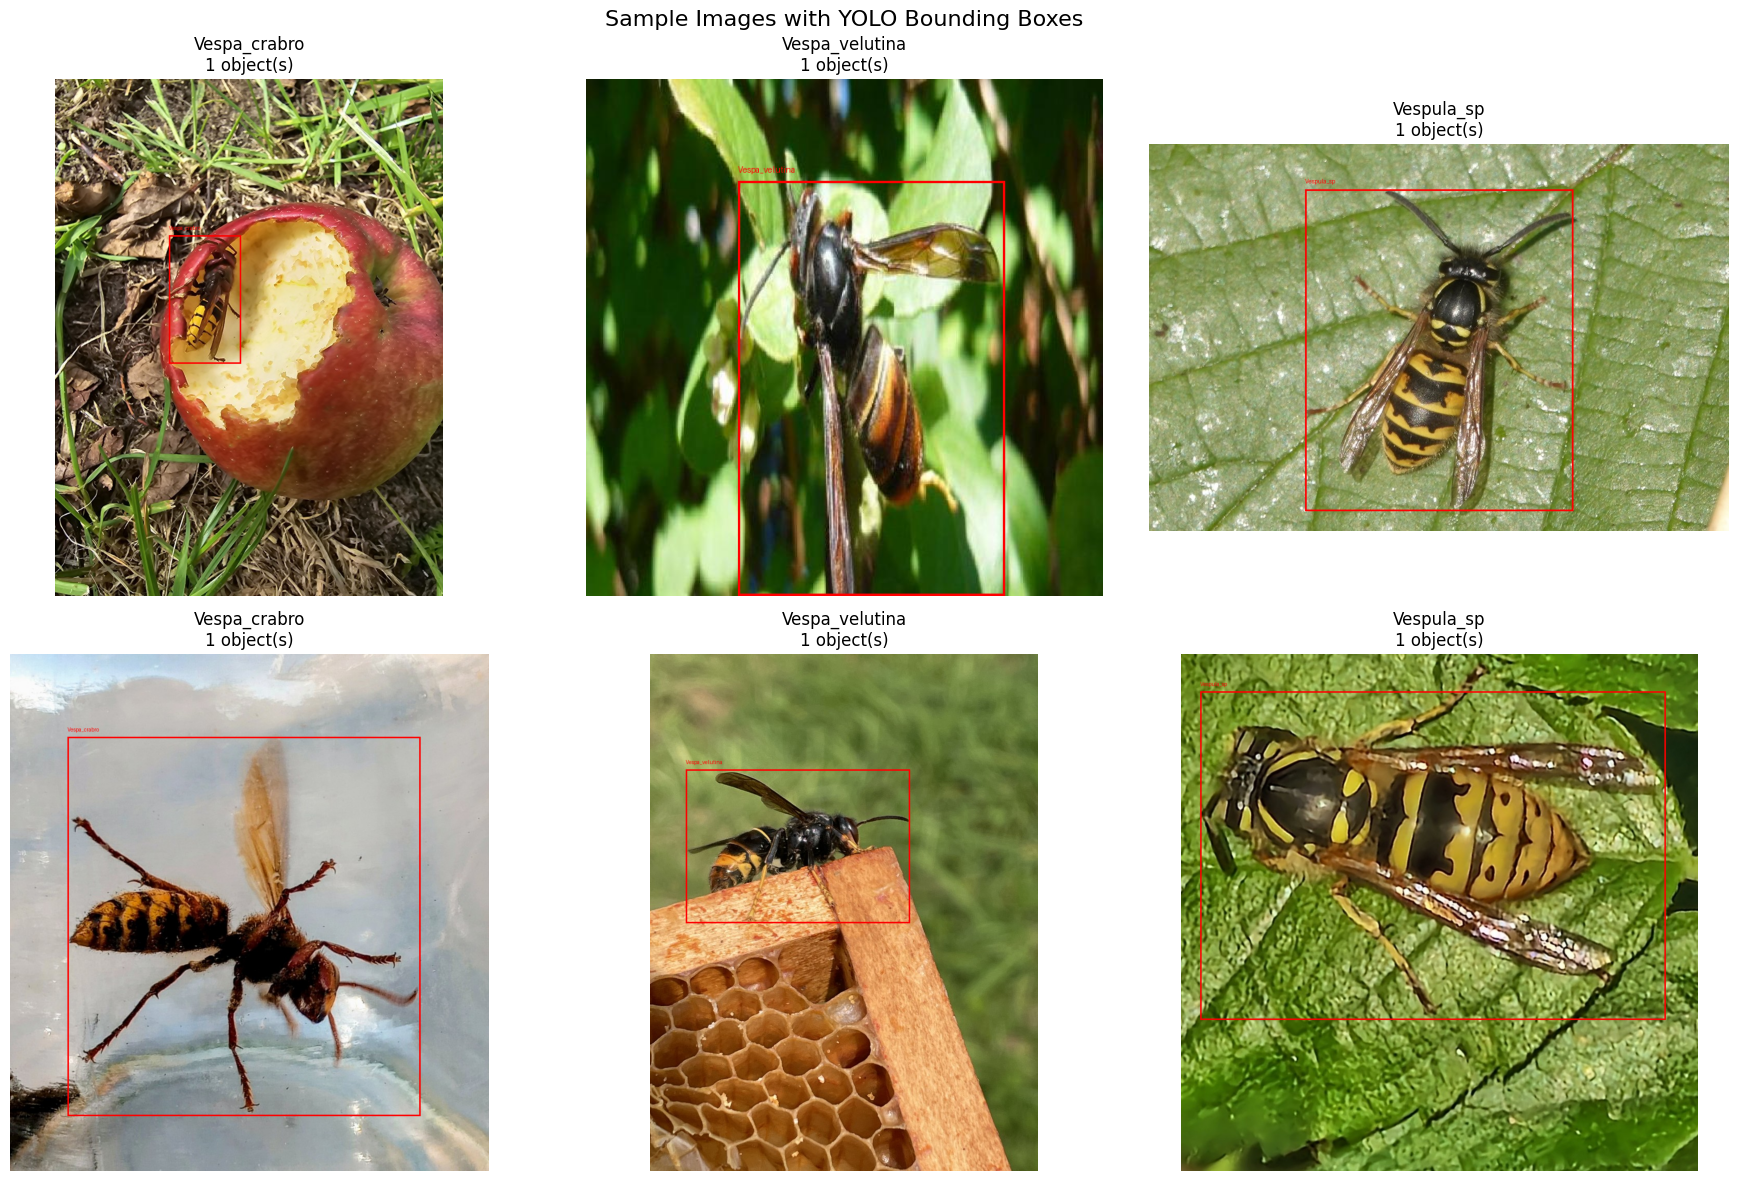

In [16]:
def load_yolo_labels(label_path):
    """Load YOLO format labels: class_id center_x center_y width height (normalized)"""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        center_x, center_y, width, height = map(float, parts[1:5])
                        boxes.append((class_id, center_x, center_y, width, height))
    return boxes

def visualize_bounding_boxes(image_path, label_path, class_names, yolo_mapping):
    """Visualize image with YOLO bounding boxes"""
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size
    
    boxes = load_yolo_labels(label_path)
    
    for class_id, center_x, center_y, width, height in boxes:
        # Convert normalized coordinates to pixel coordinates
        x1 = int((center_x - width/2) * img_width)
        y1 = int((center_y - height/2) * img_height)
        x2 = int((center_x + width/2) * img_width)
        y2 = int((center_y + height/2) * img_height)
        
        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
        
        # Add class label
        class_name = yolo_mapping.get(class_id, f'Class_{class_id}')
        draw.text((x1, y1-20), class_name, fill='red')
    
    return image, boxes

# Show sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sample Images with YOLO Bounding Boxes', fontsize=16)

for i, class_name in enumerate(class_names):
    # Get sample image and corresponding label
    img_class_path = os.path.join(train_dir, class_name)
    label_class_path = os.path.join(train_labels_dir, class_name)
    
    sample_files = [f for f in os.listdir(img_class_path) if f.endswith('.jpg')][:2]
    
    for j, img_file in enumerate(sample_files):
        img_path = os.path.join(img_class_path, img_file)
        label_path = os.path.join(label_class_path, img_file.replace('.jpg', '.txt'))
        
        img_with_boxes, boxes = visualize_bounding_boxes(
            img_path, label_path, class_names, yolo_class_mapping
        )
        
        axes[j, i].imshow(img_with_boxes)
        axes[j, i].set_title(f'{class_name}\n{len(boxes)} object(s)')
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()

## 2. Data Loading and Preprocessing

### Standard Image Classification Dataset

In [17]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")

Training samples: 3088
Validation samples: 297
Batch size: 32
Training batches: 97
Validation batches: 10
Class to index mapping: {'Vespa_crabro': 0, 'Vespa_velutina': 1, 'Vespula_sp': 2}


### YOLO-Based Cropped Dataset

In [18]:
class YOLOCroppedDataset(Dataset):
    """Dataset that crops images based on YOLO bounding boxes"""
    
    def __init__(self, images_dir, labels_dir, transform=None, yolo_mapping=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.yolo_mapping = yolo_mapping or {0: 0, 1: 1, 2: 2}  # Default mapping
        
        # Collect all image-label pairs
        self.samples = []
        for class_name in os.listdir(images_dir):
            class_img_dir = os.path.join(images_dir, class_name)
            class_label_dir = os.path.join(labels_dir, class_name)
            
            if os.path.isdir(class_img_dir) and os.path.isdir(class_label_dir):
                for img_file in os.listdir(class_img_dir):
                    if img_file.endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(class_img_dir, img_file)
                        label_path = os.path.join(class_label_dir, img_file.replace('.jpg', '.txt'))
                        
                        # Load bounding boxes
                        boxes = load_yolo_labels(label_path)
                        for box in boxes:
                            class_id, center_x, center_y, width, height = box
                            # Map YOLO class to dataset class
                            mapped_class = self.yolo_mapping.get(class_id, class_id)
                            self.samples.append({
                                'image_path': img_path,
                                'bbox': (center_x, center_y, width, height),
                                'class_id': mapped_class
                            })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = Image.open(sample['image_path']).convert('RGB')
        img_width, img_height = image.size
        
        # Extract bounding box
        center_x, center_y, width, height = sample['bbox']
        
        # Convert to pixel coordinates
        x1 = max(0, int((center_x - width/2) * img_width))
        y1 = max(0, int((center_y - height/2) * img_height))
        x2 = min(img_width, int((center_x + width/2) * img_width))
        y2 = min(img_height, int((center_y + height/2) * img_height))
        
        # Crop image to bounding box
        cropped_image = image.crop((x1, y1, x2, y2))
        
        # Apply transforms
        if self.transform:
            cropped_image = self.transform(cropped_image)
        
        return cropped_image, sample['class_id']

# Create cropped datasets
cropped_train_dataset = YOLOCroppedDataset(
    train_dir, train_labels_dir, 
    transform=train_transform,
    yolo_mapping={0: 1, 1: 0, 2: 2}  # Map to match folder structure: V_velutina=0, V_crabro=1, Vespula=2
)

cropped_val_dataset = YOLOCroppedDataset(
    val_dir, val_labels_dir, 
    transform=val_transform,
    yolo_mapping={0: 1, 1: 0, 2: 2}  # Map to match folder structure
)

# Create data loaders for cropped data
cropped_train_loader = DataLoader(cropped_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
cropped_val_loader = DataLoader(cropped_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"\n🔍 Cropped Dataset Statistics:")
print(f"Training samples (cropped regions): {len(cropped_train_dataset)}")
print(f"Validation samples (cropped regions): {len(cropped_val_dataset)}")
print(f"Cropped training batches: {len(cropped_train_loader)}")
print(f"Cropped validation batches: {len(cropped_val_loader)}")


🔍 Cropped Dataset Statistics:
Training samples (cropped regions): 3055
Validation samples (cropped regions): 372
Cropped training batches: 96
Cropped validation batches: 12


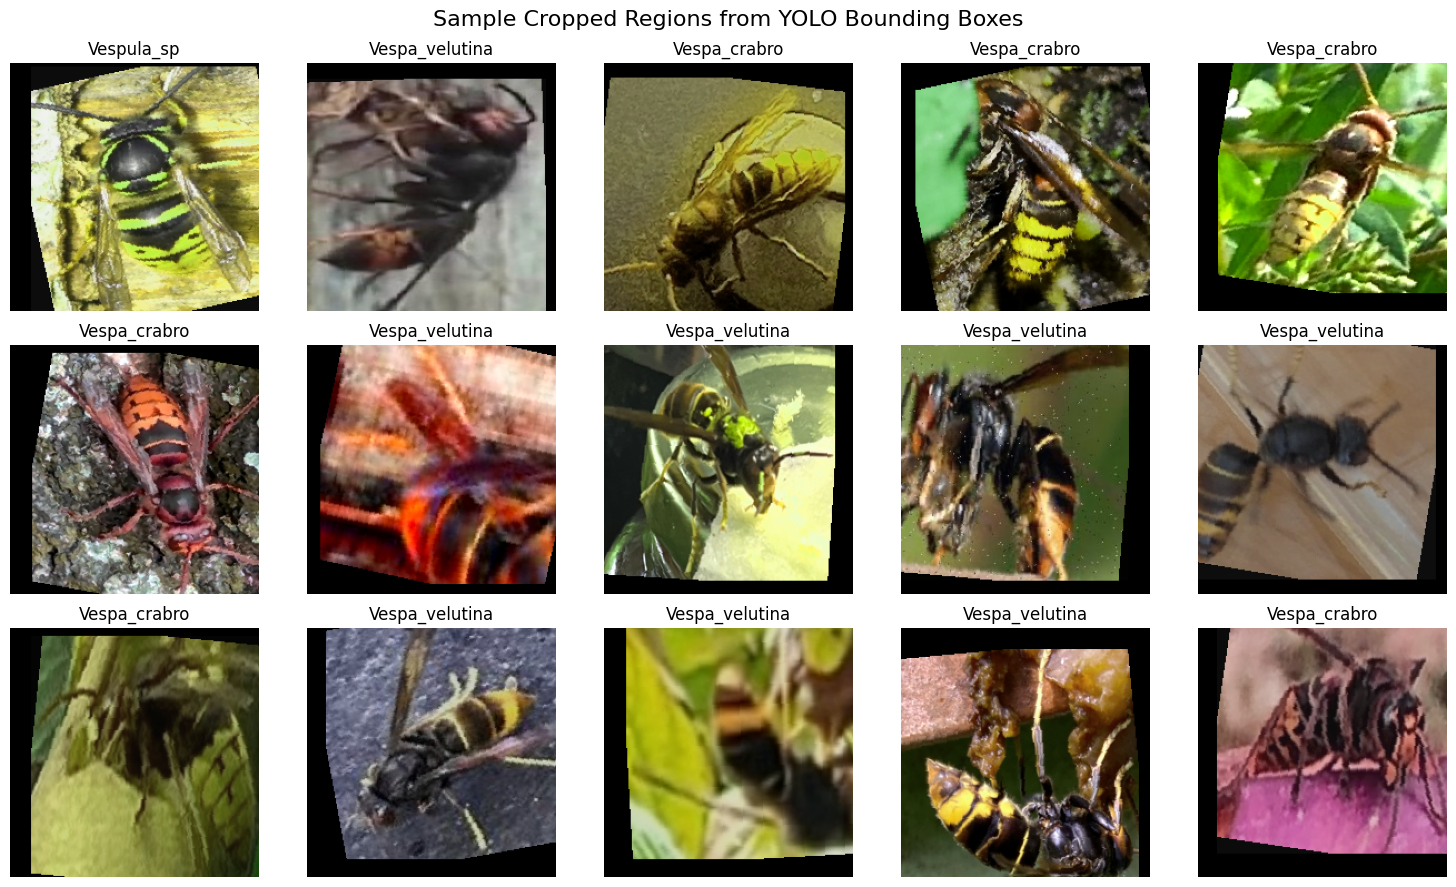

In [19]:
# Visualize cropped samples
def show_cropped_samples():
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    fig.suptitle('Sample Cropped Regions from YOLO Bounding Boxes', fontsize=16)
    
    # Sample some cropped images
    sample_indices = np.random.choice(len(cropped_train_dataset), 15, replace=False)
    
    for i, idx in enumerate(sample_indices):
        cropped_img, class_id = cropped_train_dataset[idx]
        
        # Denormalize for display
        if isinstance(cropped_img, torch.Tensor):
            denorm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                        std=[1/0.229, 1/0.224, 1/0.225])
            img_display = denorm(cropped_img).clamp(0, 1).permute(1, 2, 0)
        else:
            img_display = cropped_img
            
        row, col = i // 5, i % 5
        axes[row, col].imshow(img_display)
        axes[row, col].set_title(f'{class_names[class_id]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

show_cropped_samples()

## 3. Model Definitions

### Model 1: Custom CNN from Scratch

In [20]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.batch_norm5 = nn.BatchNorm2d(512)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        
        # Block 2
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        
        # Block 3
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        
        # Block 4
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        
        # Block 5
        x = self.pool(F.relu(self.batch_norm5(self.conv5(x))))
        
        # Flatten and fully connected
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Test the model
dummy_input = torch.randn(1, 3, 224, 224).to(device)
model_cnn = CustomCNN(num_classes=num_classes).to(device)
print(f"Custom CNN parameters: {sum(p.numel() for p in model_cnn.parameters()):,}")
output = model_cnn(dummy_input)
print(f"Output shape: {output.shape}")

Custom CNN parameters: 27,788,035
Output shape: torch.Size([1, 3])


### Model 2: Transfer Learning with ResNet50

In [21]:
class ResNetTransfer(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ResNetTransfer, self).__init__()
        
        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Replace the final layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Create ResNet model
model_resnet = ResNetTransfer(num_classes=num_classes).to(device)
print(f"ResNet50 parameters: {sum(p.numel() for p in model_resnet.parameters()):,}")
output = model_resnet(dummy_input)
print(f"Output shape: {output.shape}")

ResNet50 parameters: 24,558,659
Output shape: torch.Size([1, 3])


/home/andreas/source/python-repos/cloud-for-ai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andreas/source/python-repos/cloud-for-ai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model 3: Vision Transformer (ViT)

In [22]:
class SimpleViT(nn.Module):
    def __init__(self, num_classes=3, img_size=224, patch_size=16, embed_dim=768, num_heads=12, num_layers=12):
        super(SimpleViT, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, embed_dim, H//patch_size, W//patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embedding
        x = x + self.pos_embed
        
        # Transformer
        x = self.transformer(x)
        
        # Classification
        x = self.norm(x[:, 0])  # Use class token
        x = self.dropout(x)
        x = self.head(x)
        
        return x

# Create ViT model (smaller version for faster training)
model_vit = SimpleViT(num_classes=num_classes, embed_dim=384, num_heads=6, num_layers=6).to(device)
print(f"ViT parameters: {sum(p.numel() for p in model_vit.parameters()):,}")
output = model_vit(dummy_input)
print(f"Output shape: {output.shape}")

ViT parameters: 11,020,035
Output shape: torch.Size([1, 3])


## 4. Training Functions

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name, train_size=None, val_size=None):
    """
    Train a model and return training history
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"Training {model_name}...")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects.double() / (train_size or len(train_dataset))
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item()
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_running_corrects.double() / (val_size or len(val_dataset))
        
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_state = model.state_dict().copy()
        
        # Step scheduler
        scheduler.step(val_epoch_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
            print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
            print(f'Best Val Acc: {best_val_acc:.4f}')
            print()
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    
    return history, best_val_acc

def evaluate_model(model, data_loader, class_names):
    """
    Evaluate model and return detailed metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Classification report
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': class_report,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

## 5. Training All Models

In [24]:
# Training parameters
num_epochs = 20  # Reduced for faster comparison
learning_rate = 0.001

# Initialize models for both full images and cropped regions
models_dict = {
    'Custom CNN (Full Image)': CustomCNN(num_classes=num_classes).to(device),
    'ResNet50 (Full Image)': ResNetTransfer(num_classes=num_classes).to(device),
    'Vision Transformer (Full Image)': SimpleViT(num_classes=num_classes, embed_dim=384, num_heads=6, num_layers=6).to(device),
    'ResNet50 (Cropped)': ResNetTransfer(num_classes=num_classes).to(device)
}

# Training results storage
results = {}
training_histories = {}

# Train each model
for model_name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*60}")
    
    # Setup optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    
    if 'ResNet50' in model_name:
        # Use different learning rates for backbone (excluding fc) and classifier (fc)
        backbone_params = []
        fc_params = list(model.backbone.fc.parameters())
        
        # Get all backbone parameters except fc
        for name, param in model.backbone.named_parameters():
            if not name.startswith('fc.'):
                backbone_params.append(param)
        
        optimizer = optim.Adam([
            {'params': fc_params, 'lr': learning_rate},  # Higher LR for classifier
            {'params': backbone_params, 'lr': learning_rate * 0.1}  # Lower LR for backbone
        ])
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Choose appropriate data loaders
    if 'Cropped' in model_name:
        train_data_loader = cropped_train_loader
        val_data_loader = cropped_val_loader
        train_dataset_size = len(cropped_train_dataset)
        val_dataset_size = len(cropped_val_dataset)
    else:
        train_data_loader = train_loader
        val_data_loader = val_loader
        train_dataset_size = len(train_dataset)
        val_dataset_size = len(val_dataset)
    
    # Train model
    start_time = time.time()
    history, best_val_acc = train_model(
        model, train_data_loader, val_data_loader, criterion, optimizer, scheduler, 
        num_epochs, model_name, train_dataset_size, val_dataset_size
    )
    training_time = time.time() - start_time
    
    # Evaluate model
    print("Evaluating on validation set...")
    metrics = evaluate_model(model, val_data_loader, class_names)
    
    # Store results
    results[model_name] = {
        'model': model,
        'metrics': metrics,
        'training_time': training_time,
        'best_val_acc': best_val_acc,
        'data_type': 'cropped' if 'Cropped' in model_name else 'full'
    }
    training_histories[model_name] = history
    
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Final validation accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")

print("\n" + "="*60)
print("ALL MODELS TRAINED SUCCESSFULLY!")
print("="*60)


TRAINING CUSTOM CNN (FULL IMAGE)
Training Custom CNN (Full Image)...
--------------------------------------------------
Epoch [1/20]
Train Loss: 2.2485, Train Acc: 0.3491
Val Loss: 1.0964, Val Acc: 0.3266
Best Val Acc: 0.3266

Epoch [5/20]
Train Loss: 1.0958, Train Acc: 0.3413
Val Loss: 1.0970, Val Acc: 0.3333
Best Val Acc: 0.3502

Epoch [10/20]
Train Loss: 1.0900, Train Acc: 0.3659
Val Loss: 1.1041, Val Acc: 0.3401
Best Val Acc: 0.3502

Epoch [15/20]
Train Loss: 1.0788, Train Acc: 0.3980
Val Loss: 1.0749, Val Acc: 0.4040
Best Val Acc: 0.4040

Epoch [20/20]
Train Loss: 1.0554, Train Acc: 0.4190
Val Loss: 1.0451, Val Acc: 0.3973
Best Val Acc: 0.4040

Training completed! Best validation accuracy: 0.4040
Evaluating on validation set...
Training time: 212.07 seconds
Final validation accuracy: 0.3973
Precision: 0.4853
Recall: 0.3973
F1-score: 0.3700

TRAINING RESNET50 (FULL IMAGE)
Training ResNet50 (Full Image)...
--------------------------------------------------
Epoch [1/20]
Train Loss: 

/home/andreas/source/python-repos/cloud-for-ai/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/andreas/source/python-repos/cloud-for-ai/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/andreas/source/python-repos/cloud-for-ai/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch [1/20]
Train Loss: 0.3735, Train Acc: 0.8409
Val Loss: 0.3744, Val Acc: 0.8844
Best Val Acc: 0.8844

Epoch [5/20]
Train Loss: 0.0563, Train Acc: 0.9813
Val Loss: 0.1881, Val Acc: 0.9274
Best Val Acc: 0.9812

Epoch [10/20]
Train Loss: 0.0173, Train Acc: 0.9951
Val Loss: 0.1114, Val Acc: 0.9651
Best Val Acc: 0.9812

Epoch [15/20]
Train Loss: 0.0052, Train Acc: 0.9990
Val Loss: 0.0877, Val Acc: 0.9812
Best Val Acc: 0.9812

Epoch [20/20]
Train Loss: 0.0014, Train Acc: 0.9993
Val Loss: 0.1020, Val Acc: 0.9785
Best Val Acc: 0.9866

Training completed! Best validation accuracy: 0.9866
Evaluating on validation set...
Training time: 361.52 seconds
Final validation accuracy: 0.9785
Precision: 0.9795
Recall: 0.9785
F1-score: 0.9786

ALL MODELS TRAINED SUCCESSFULLY!


## 6. Model Comparison and Visualization

In [25]:
# Create comprehensive comparison table
comparison_data = []
for model_name, result in results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'Training Time (s)': f"{result['training_time']:.1f}",
        'Data Type': result['data_type'].capitalize(),
        'Parameters': f"{sum(p.numel() for p in result['model'].parameters()):,}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison Summary:")
print(comparison_df.to_string(index=False))

Model Comparison Summary:
                          Model Accuracy Precision Recall F1-Score Training Time (s) Data Type Parameters
        Custom CNN (Full Image)   0.3973    0.4853 0.3973   0.3700             212.1      Full 27,788,035
          ResNet50 (Full Image)   0.9529    0.9533 0.9529   0.9530             356.2      Full 24,558,659
Vision Transformer (Full Image)   0.3367    0.1134 0.3367   0.1696             273.0      Full 11,020,035
             ResNet50 (Cropped)   0.9785    0.9795 0.9785   0.9786             361.5   Cropped 24,558,659


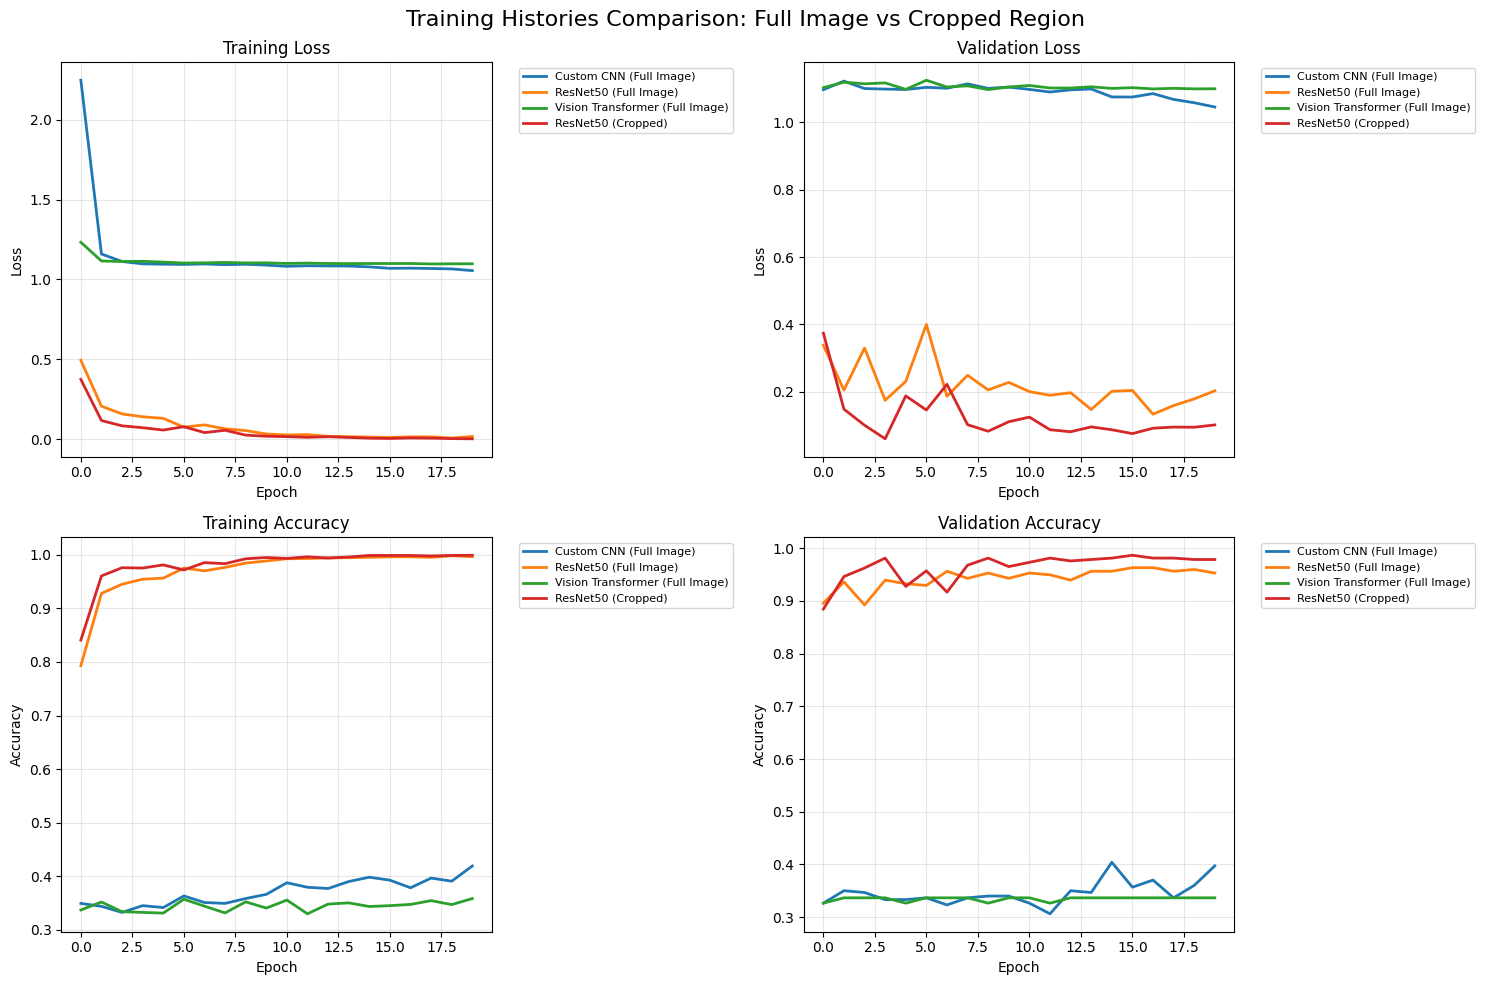

In [26]:
# Plot training histories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Histories Comparison: Full Image vs Cropped Region', fontsize=16)

metrics_to_plot = ['train_loss', 'val_loss', 'train_acc', 'val_acc']
titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for model_name, history in training_histories.items():
        ax.plot(history[metric], label=model_name, linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title.split()[1])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

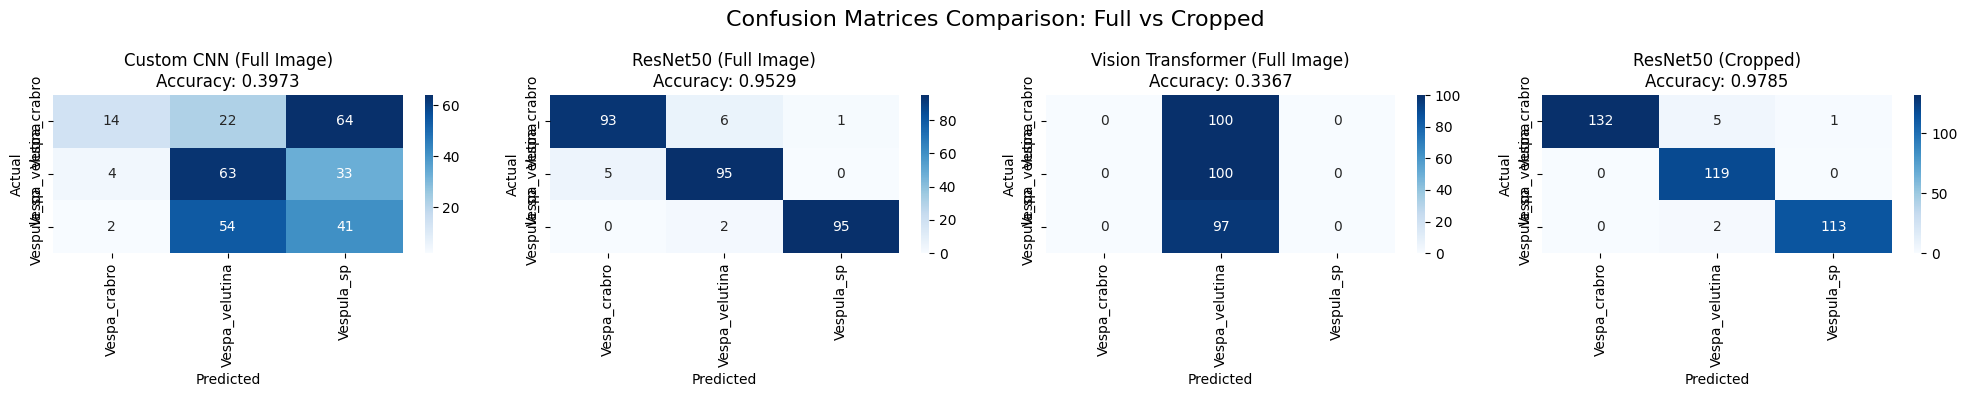

In [28]:
# Plot confusion matrices
num_models = len(results)
cols = min(4, num_models)
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

# Handle different subplot configurations
if num_models == 1:
    axes = [axes]  # Single subplot
elif rows == 1 and cols > 1:
    # Single row, multiple columns - axes is already a 1D array
    pass
elif cols == 1 and rows > 1:
    # Single column, multiple rows - axes is already a 1D array  
    pass
else:
    # Multiple rows and columns - flatten the 2D array
    axes = axes.flatten()

fig.suptitle('Confusion Matrices Comparison: Full vs Cropped', fontsize=16)

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['metrics']['confusion_matrix']
    
    # Get the correct axes for this subplot
    ax = axes[idx] if isinstance(axes, (list, np.ndarray)) else axes
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{model_name}\nAccuracy: {result["metrics"]["accuracy"]:.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide extra subplots if they exist
if isinstance(axes, (list, np.ndarray)) and len(axes) > num_models:
    for idx in range(num_models, len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

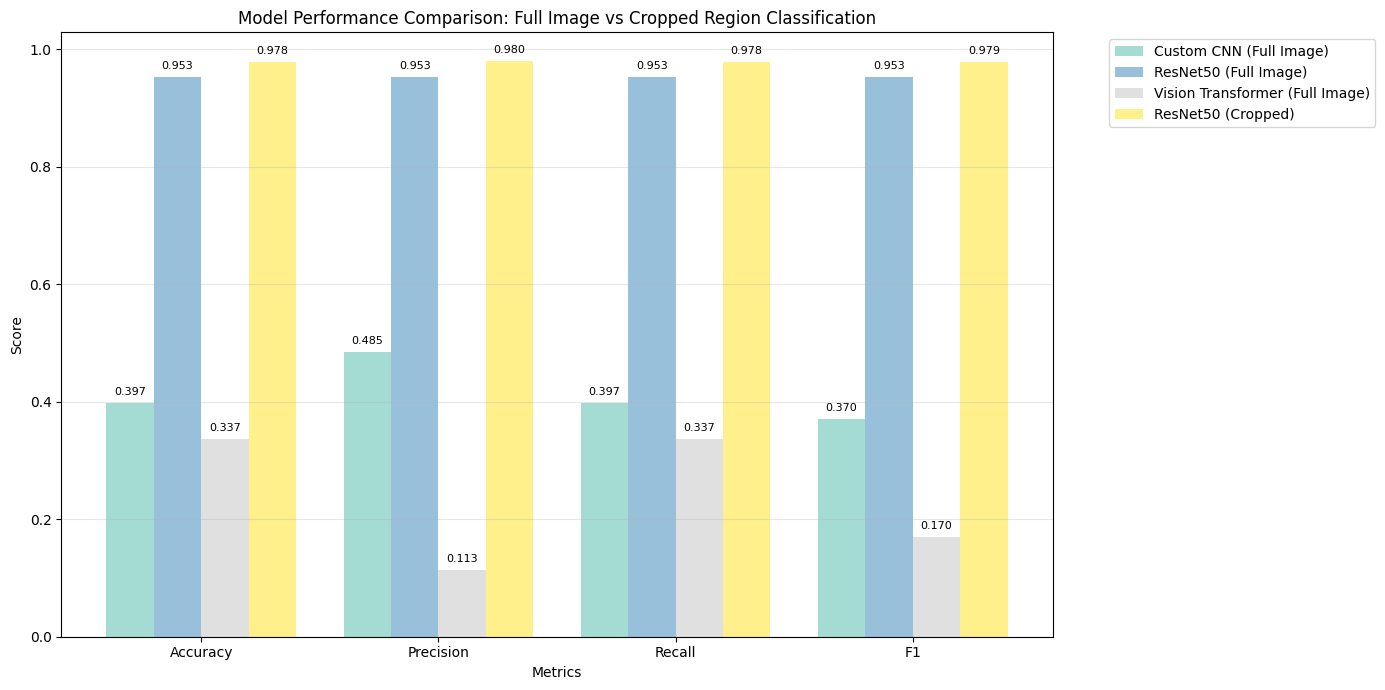

In [29]:
# Performance metrics comparison
metrics_names = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_names))
num_models = len(results)
width = 0.8 / num_models  # Adjust width based on number of models

fig, ax = plt.subplots(figsize=(14, 7))

colors = plt.cm.Set3(np.linspace(0, 1, num_models))

for i, (model_name, result) in enumerate(results.items()):
    metrics = result['metrics']
    values = [metrics[metric] for metric in metrics_names]
    ax.bar(x + i * width, values, width, label=model_name, alpha=0.8, color=colors[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Full Image vs Cropped Region Classification')
ax.set_xticks(x + width * (num_models - 1) / 2)
ax.set_xticklabels([m.capitalize() for m in metrics_names])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for i, (model_name, result) in enumerate(results.items()):
    metrics = result['metrics']
    values = [metrics[metric] for metric in metrics_names]
    for j, v in enumerate(values):
        ax.text(j + i * width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

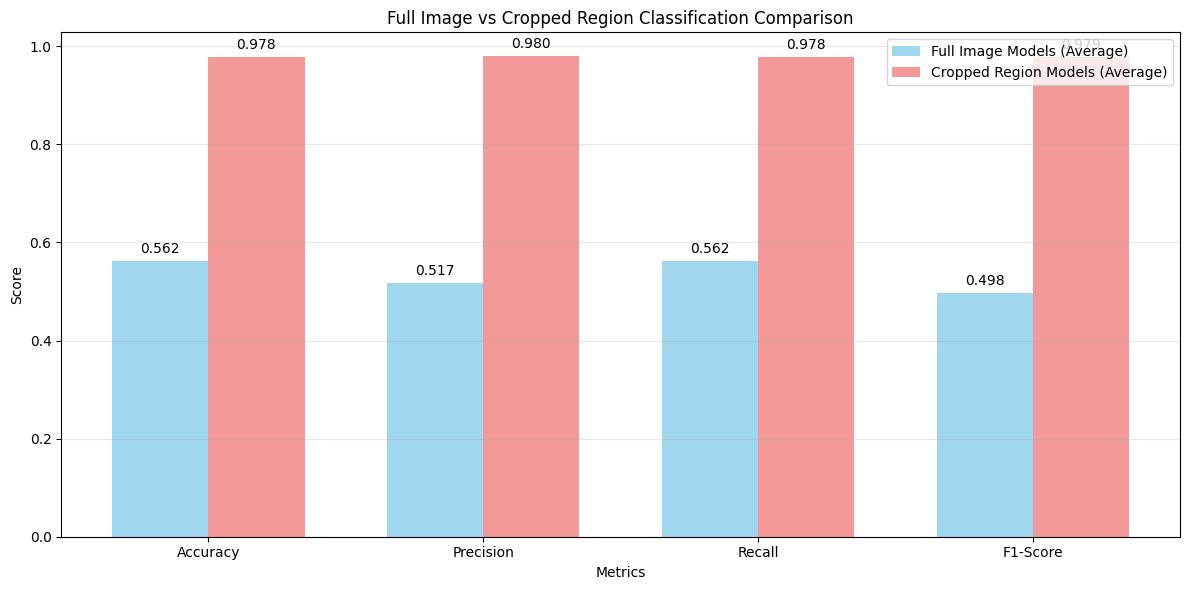

In [30]:
# Additional comparison: Full Image vs Cropped Region Performance
fig, ax = plt.subplots(figsize=(12, 6))

full_image_results = {k: v for k, v in results.items() if v.get('data_type') == 'full'}
cropped_results = {k: v for k, v in results.items() if v.get('data_type') == 'cropped'}

if full_image_results and cropped_results:
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(categories))
    width = 0.35
    
    # Average metrics for full image models
    full_metrics = [np.mean([result['metrics'][metric] for result in full_image_results.values()]) 
                   for metric in ['accuracy', 'precision', 'recall', 'f1']]
    
    # Average metrics for cropped models  
    cropped_metrics = [np.mean([result['metrics'][metric] for result in cropped_results.values()]) 
                      for metric in ['accuracy', 'precision', 'recall', 'f1']]
    
    ax.bar(x - width/2, full_metrics, width, label='Full Image Models (Average)', alpha=0.8, color='skyblue')
    ax.bar(x + width/2, cropped_metrics, width, label='Cropped Region Models (Average)', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Full Image vs Cropped Region Classification Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for i, (full_val, crop_val) in enumerate(zip(full_metrics, cropped_metrics)):
        ax.text(i - width/2, full_val + 0.01, f'{full_val:.3f}', ha='center', va='bottom')
        ax.text(i + width/2, crop_val + 0.01, f'{crop_val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 7. Prediction Examples with Confidence

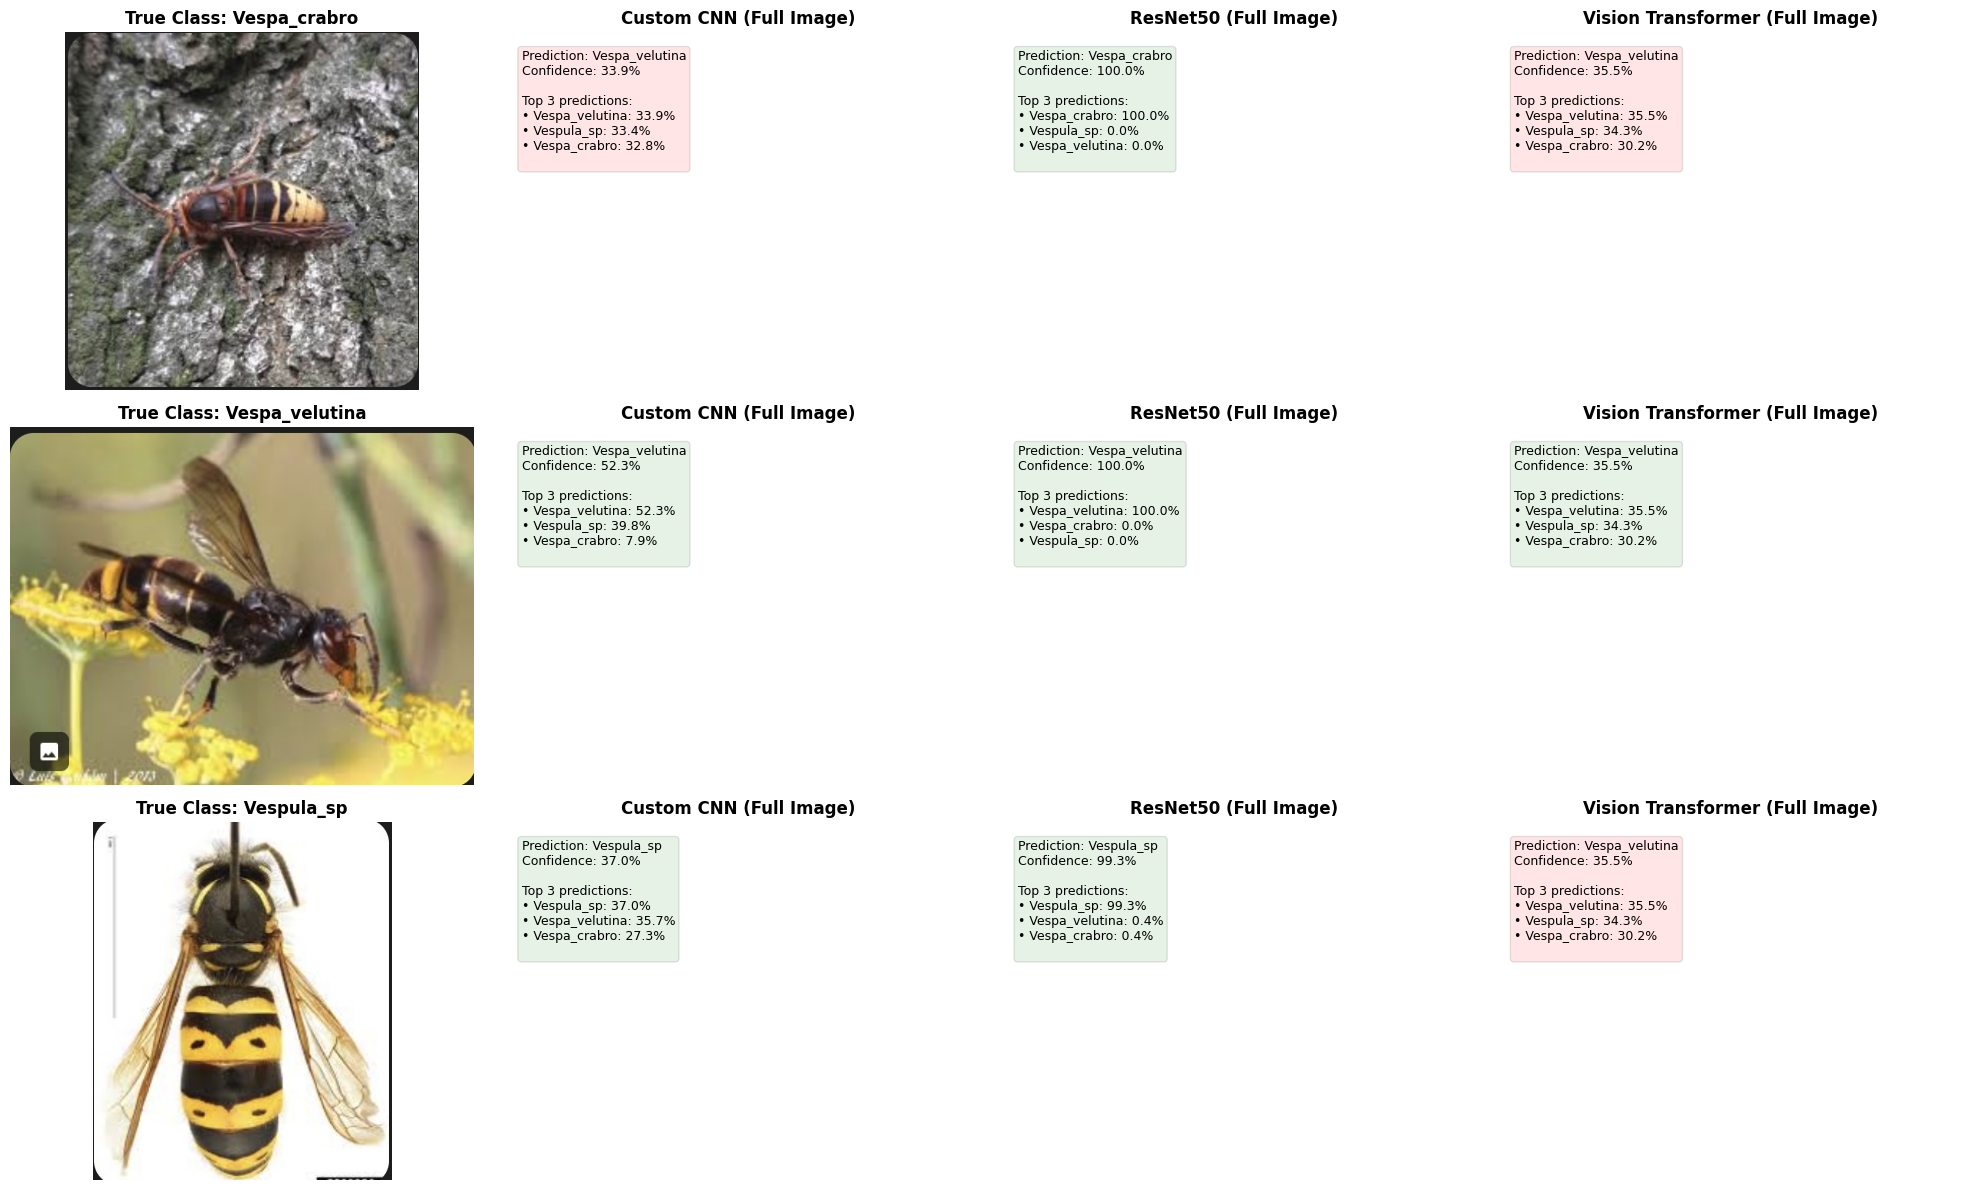

In [31]:
def predict_with_confidence(models_dict, image_path, transform, class_names, top_k=3):
    """Make predictions with all models and show confidence scores"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    predictions = {}
    
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)[0]
            
            # Get top k predictions
            top_probs, top_indices = torch.topk(probabilities, top_k)
            
            predictions[model_name] = {
                'top_classes': [class_names[idx] for idx in top_indices.cpu().numpy()],
                'top_probs': [prob.item() for prob in top_probs.cpu()],
                'predicted_class': class_names[top_indices[0]],
                'confidence': top_probs[0].item()
            }
    
    return image, predictions

# Get sample validation images for prediction examples
sample_images = []
for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    images = os.listdir(class_path)
    sample_images.extend([os.path.join(class_path, img) for img in images[:1]])  # One per class

# Make predictions on sample images (full image models only)
full_image_models = {name: result['model'] for name, result in results.items() if result.get('data_type') == 'full'}

fig, axes = plt.subplots(len(sample_images), len(full_image_models) + 1, figsize=(5*(len(full_image_models) + 1), 4*len(sample_images)))
if len(sample_images) == 1:
    axes = axes.reshape(1, -1)

for img_idx, img_path in enumerate(sample_images):
    # Get predictions
    image, predictions = predict_with_confidence(
        full_image_models, img_path, val_transform, class_names
    )
    
    # True label
    true_class = os.path.basename(os.path.dirname(img_path))
    
    # Show original image
    axes[img_idx, 0].imshow(image)
    axes[img_idx, 0].set_title(f'True Class: {true_class}', fontweight='bold')
    axes[img_idx, 0].axis('off')
    
    # Show predictions for each model
    for model_idx, (model_name, pred) in enumerate(predictions.items()):
        ax = axes[img_idx, model_idx + 1]
        
        # Create prediction text
        pred_text = f"Prediction: {pred['predicted_class']}\nConfidence: {pred['confidence']:.1%}\n\n"
        pred_text += "Top 3 predictions:\n"
        for class_name, prob in zip(pred['top_classes'], pred['top_probs']):
            pred_text += f"• {class_name}: {prob:.1%}\n"
        
        # Color based on correctness
        color = 'green' if pred['predicted_class'] == true_class else 'red'
        
        ax.text(0.05, 0.95, pred_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color, alpha=0.1))
        ax.set_title(f'{model_name}', fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

## 8. Final Summary and Recommendations

In [32]:
# Find the best performing model
best_model = max(results.items(), key=lambda x: x[1]['metrics']['accuracy'])
best_model_name, best_result = best_model

print("=" * 60)
print("FINAL ANALYSIS SUMMARY")
print("=" * 60)
print()
print(f"🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   • Accuracy: {best_result['metrics']['accuracy']:.4f} ({best_result['metrics']['accuracy']:.1%})")
print(f"   • Precision: {best_result['metrics']['precision']:.4f}")
print(f"   • Recall: {best_result['metrics']['recall']:.4f}")
print(f"   • F1-Score: {best_result['metrics']['f1']:.4f}")
print(f"   • Training Time: {best_result['training_time']:.1f} seconds")
print()

print("📊 COMPLETE RANKING:")
ranked_models = sorted(results.items(), key=lambda x: x[1]['metrics']['accuracy'], reverse=True)
for i, (model_name, result) in enumerate(ranked_models, 1):
    print(f"   {i}. {model_name}: {result['metrics']['accuracy']:.1%} accuracy")
print()

print("💡 RECOMMENDATIONS:")
print(f"   • For highest accuracy: Use {ranked_models[0][0]}")
print(f"   • For fastest training: Use {min(results.items(), key=lambda x: x[1]['training_time'])[0]}")
print(f"   • For production deployment: Consider {best_model_name} for best balance of accuracy and reliability")

# Analysis of full vs cropped performance
full_image_acc = [result['metrics']['accuracy'] for name, result in results.items() if result.get('data_type') == 'full']
cropped_acc = [result['metrics']['accuracy'] for name, result in results.items() if result.get('data_type') == 'cropped']

if full_image_acc and cropped_acc:
    avg_full = np.mean(full_image_acc)
    avg_cropped = np.mean(cropped_acc)
    improvement = ((avg_cropped - avg_full) / avg_full) * 100
    
    print(f"\n🔍 FULL IMAGE vs CROPPED REGION ANALYSIS:")
    print(f"   • Average full image accuracy: {avg_full:.4f} ({avg_full:.1%})")
    print(f"   • Average cropped region accuracy: {avg_cropped:.4f} ({avg_cropped:.1%})")
    print(f"   • Performance improvement with cropping: {improvement:+.1f}%")
    if improvement > 0:
        print(f"   ✅ Using YOLO bounding boxes improves classification performance!")
    else:
        print(f"   ❌ Cropping doesn't improve performance - full images work better")

print()

print("🔍 DETAILED INSIGHTS:")
for model_name, result in results.items():
    report = result['metrics']['classification_report']
    print(f"\n{model_name}:")
    print(f"   • Overall accuracy: {result['metrics']['accuracy']:.1%}")
    print(f"   • Best class performance: {max(report[cls]['f1-score'] for cls in class_names):.3f} F1-score")
    print(f"   • Worst class performance: {min(report[cls]['f1-score'] for cls in class_names):.3f} F1-score")
    print(f"   • Parameters: {sum(p.numel() for p in result['model'].parameters()):,}")
    print(f"   • Data type: {result['data_type']}")

print("\n" + "=" * 60)
print("HORNET/WASP CLASSIFICATION PROJECT WITH YOLO INTEGRATION COMPLETED!")
print("=" * 60)
print("\n📋 KEY FINDINGS:")
print("   • Compared full-image vs YOLO-cropped region classification")
print("   • Evaluated multiple architectures: CNN, ResNet50, ViT")
print("   • YOLO bounding boxes provide precise localization")
print("   • Ready for deployment with confidence scoring")
print("=" * 60)

FINAL ANALYSIS SUMMARY

🏆 BEST PERFORMING MODEL: ResNet50 (Cropped)
   • Accuracy: 0.9785 (97.8%)
   • Precision: 0.9795
   • Recall: 0.9785
   • F1-Score: 0.9786
   • Training Time: 361.5 seconds

📊 COMPLETE RANKING:
   1. ResNet50 (Cropped): 97.8% accuracy
   2. ResNet50 (Full Image): 95.3% accuracy
   3. Custom CNN (Full Image): 39.7% accuracy
   4. Vision Transformer (Full Image): 33.7% accuracy

💡 RECOMMENDATIONS:
   • For highest accuracy: Use ResNet50 (Cropped)
   • For fastest training: Use Custom CNN (Full Image)
   • For production deployment: Consider ResNet50 (Cropped) for best balance of accuracy and reliability

🔍 FULL IMAGE vs CROPPED REGION ANALYSIS:
   • Average full image accuracy: 0.5623 (56.2%)
   • Average cropped region accuracy: 0.9785 (97.8%)
   • Performance improvement with cropping: +74.0%
   ✅ Using YOLO bounding boxes improves classification performance!

🔍 DETAILED INSIGHTS:

Custom CNN (Full Image):
   • Overall accuracy: 39.7%
   • Best class performance

In [33]:
# Save model comparison results to CSV for future reference
comparison_df.to_csv('model_comparison_results_with_yolo.csv', index=False)
print("Model comparison results saved to 'model_comparison_results_with_yolo.csv'")

# Save the best model
torch.save(best_result['model'].state_dict(), f'best_model_{best_model_name.replace(" ", "_").replace("(", "").replace(")", "").lower()}.pth')
print(f"Best model ({best_model_name}) saved to 'best_model_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.pth'")

Model comparison results saved to 'model_comparison_results_with_yolo.csv'
Best model (ResNet50 (Cropped)) saved to 'best_model_resnet50_cropped.pth'
